# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
Author: Mas Chano <br />
Date: 2017/05/09

***

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
import numpy as np
import math
import cv2
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# Plotting Functions
def plot_subplots(images, titles, num_cols):
    num_images = len(images)
    num_rows = math.ceil(num_images / num_cols)
    plt.figure(figsize=(10*num_cols, 6*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(titles[i])
        plt.imshow(images[i])

## Rubric: Camera Calibration
The following section shows how the camera was calibrated. Because the lens of the camera introduces distortions, we use chessboard pattern calibration images to calculate the camera matrix and distortion coefficients which can then be used to correct for the effects of distortion. 

Here chessboard pattern calibration images that contain 9 horizontal and 6 vertical internal corners are loaded. For each calibration image, `cv2.findChessboardCorners` is used to identify the coordinates of the chessboard corners in the 2D calibration image. A list of object points, equally spaced in 3D space (x, y, z) where z=0, are also created. The x, y of the object points begin at the top left corner. 

By comparing the distorted object in the image space vs. the way the object should look in 3D space (straight, uniform), we can figure out the transformation required to 'undistort' an acquired camera image. `cv2.calibrateCamera` is used to find the camera matrix and distortion coefficient that are necessary to correct the distortion introduced by the camera. 

In [3]:
def calibrate_camera(files, nx, ny):

    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image space
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    num_valid = 0
    for file in files:
        img = cv2.imread(file)

        # Convert to grayscale and find chessboard corners. CV2 reads image as BGR. 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            num_valid += 1
        elif ret == False:
            print("Failed to detect all corners on {!r}. Image will not be used for calibration.".format(file))
    print("{}/{} images returned valid corners and were used to calibrate camera.".format(num_valid, len(files)))

    # Get camera matrix and distortion coefficients. 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [4]:
# Specify calibration image file location (i.e., chessboard images)
cal_files = glob.glob('camera_cal/*.jpg')

# Specify number of inside corners in chessboard images
nx, ny = 9, 6

# Get camera matrix and distortion coefficient. 
cal_mtx, cal_dist = calibrate_camera(cal_files, nx, ny)


Failed to detect all corners on 'camera_cal/calibration4.jpg'. Image will not be used for calibration.
Failed to detect all corners on 'camera_cal/calibration5.jpg'. Image will not be used for calibration.
Failed to detect all corners on 'camera_cal/calibration1.jpg'. Image will not be used for calibration.
17/20 images returned valid corners and were used to calibrate camera.


### Distortion Correction Examples
As can be seen from the results above, not all chessboard calibration images were used in calculating the camera matrix and distortion coefficients. These images did not contain the right number of corner points. Using the obtained calibration coefficients, we can observe the 'undistortion' effect on test images below. 

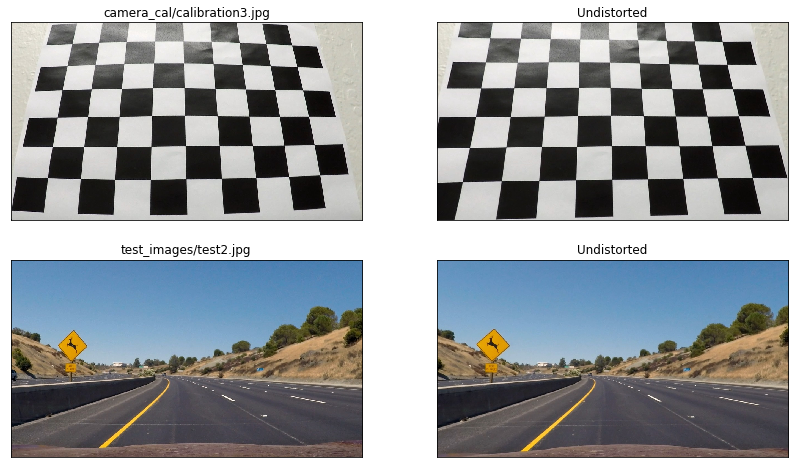

In [5]:
# Files to Undistort
chessboard_file = 'camera_cal/calibration3.jpg'
test_file = 'test_images/test2.jpg'
files = [chessboard_file, test_file]

plt.subplots(2, 2, figsize=(14, 8))
for i in range(0,2):
    img = cv2.imread(files[i]) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort input image using camera matrix 'mtx' and distortion coeff 'dist'
    undistort = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)
    
    # Plot original distorted vs. newly computed undistorted Chessboard image. 
    plt.subplot(2, 2, 2*i+1)
    plt.title(files[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.subplot(2, 2, 2*i+2)
    plt.title('Undistorted')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(undistort)

## Transform Matrix
Next, I find the Transform Matrix used to convert the 'undistorted' camera images into a bird's eye perspective. Here a stretch of straight line road was used to obtain the matrix. This enables us to 'verify' by eye whether the transform worked because straight roads should equal parallel roads in a bird's eye view. 

In [6]:
def find_transform():
    # Coordinates of the straight road points we want to use as source points for the transform. 
    # These numbers are valid for 'test_images/straight_lines1.jpg' and were obtained by measuring
    # pixels in the source and destination image. 

    src = np.float32([[589,  455],  # top left 
                      [693,  455],  # top right
                      [1050, 685],  # bottom right
                      [255,  685]]) # bottom left
    
    # Destination points in the transformed space. We leave space on the sides to ensure we can capture
    # curves in the road. 
    dst = np.float32([[300,50],
                      [980,50],
                      [980,720],
                      [300,720]])

    # Use cv2.getPerspectiveTransform() to get the transform matrix 'M' and its inverse 'Minv'
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv, src, dst


def get_meters_per_pix():
    # Get histogram
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #histogram = np.sum(gray, axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #xm_per_pix = 3.7/(rightx_base-leftx_base)
    xm_per_pix = 3.7/680
    ym_per_pix = 3/176
    return xm_per_pix, ym_per_pix

In [7]:
# Get transform matrix using test image with a straight road. 
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)

img_x, img_y = img.shape[1], img.shape[0]
img_size = (img_x, img_y)

M, Minv, src, dst = find_transform()

### Perspective Transform Example
Here the warp is performed on the color image to illustrate the conversion that takes place. The lines in blue map map how the lanes from the undistorted camera images are warped to the bird's eye view. 

It should be noted that when performing the transform in the actual pipeline, the transform is performed on a binary image (not color).  This is because the transform stretches the image at the top, effectively 'blurring' the image near the top of the lanes. This may have adverse effects on our edge detection. Therefore, in the pipeline, the binary thresholding is performed before the transform. 

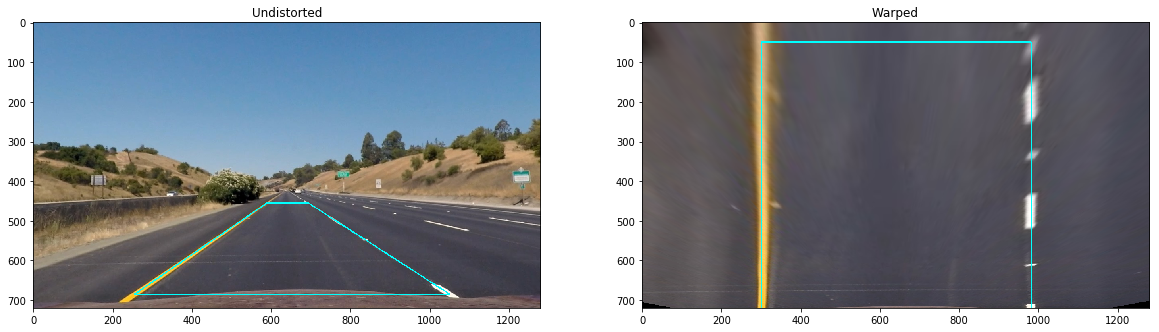

In [8]:
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# The lines show how the lanes in the undistorted images are mapped when transformed. 
cv2.polylines(img, np.array([src], dtype=np.int32), 1, (0,255,255), thickness=2)
cv2.polylines(warped, np.array([dst], dtype=np.int32), 1, (0,255,255), thickness=2)

plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.title('Undistorted')
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.title('Warped')
plt.imshow(warped)

## Processing Steps (Undistort, Threshold, etc.)
Here, several functions used to process the camera image are defined. `undistort` performs the correction defined previously. `gaussian_blur` smoothes out camera images so our edge detection using thresholding catches the 'major' edges and not 'minor' edges introduced by blemishes in the road or other edges that are not of interest to lane finding. 

In `binary_thresholding`, camera images are converted to the HLS color space to take advantage of the S-channel. This channel represents saturation and is particularly useful in catching the yellow lanes. Additionally, the sobel operation is performed in the x-direction to emphasize detection of edges that are more 'vertical'. The values for the threshold used for both the s-channel and the sobel operation in the x-direction were obtained through experimentation to minimize false edge detections. 

In [9]:
def undistort(img, cal_mtx, cal_dist):
    return cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)

In [10]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [11]:
#def binary_threshold(img, r_thresh=(100,255), s_thresh=(170, 255), sx_thresh=(40, 100)):
def binary_threshold(img, r_thresh=(100,255), s_thresh=(170, 220), sx_thresh=(40, 100)):
    img = np.copy(img)

    img = gaussian_blur(img, 5)
    
    # NOT USED: Convert to HSV color space and separate the V channel
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    #s_channel = hsv[:,:,1]
    #vl_channel = hsv[:,:,2]

    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    vl_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(vl_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

### Processing Results Examples
In the stacked view, the blue represents the results of the s-channel thresholding, while the green represents sobel x thresholding.

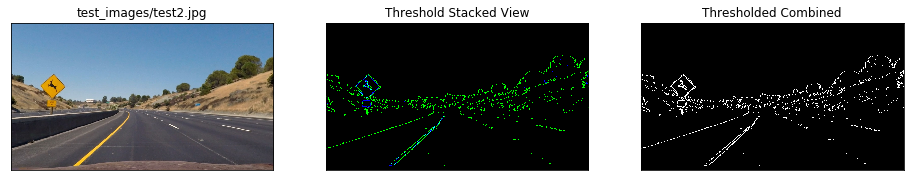

In [12]:
test_file = 'test_images/test2.jpg'
plt.figure(figsize=(16,10))

img = cv2.imread(test_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)
result_stacked, result_combined = binary_threshold(img)
plt.subplot(3, 3, 1)
plt.title(test_file)
plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.subplot(3, 3, 2)
plt.title('Threshold Stacked View')
plt.xticks([])
plt.yticks([])
plt.imshow(result_stacked)
plt.subplot(3, 3, 3)
plt.title('Thresholded Combined')
plt.xticks([])
plt.yticks([])
plt.imshow(result_combined, cmap='gray')



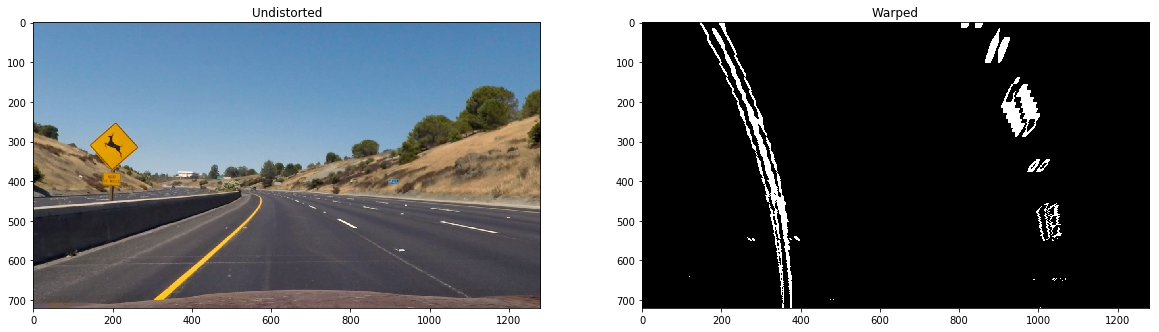

In [13]:
warped = cv2.warpPerspective(result_combined, M, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.title('Undistorted')
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.title('Warped')
plt.imshow(warped, cmap='gray')

## Define Useful Functions
Here some functions used in the pipeline are defined. 

In [14]:
from collections import deque

len_queue = 10
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=len_queue) 
        #average x values of the fitted line over the last n iterations
        #self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.recent_fit = deque(maxlen=len_queue)  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None       
        #number of skipped frames
        self.num_skipped = 0

In [15]:
def find_base(warped):
    # Get histogram of bottom half of image.    
    histogram = np.sum(warped[warped.shape[0]//2:,80:warped.shape[1]-80], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    return leftx_base, rightx_base, histogram

def find_nonzeros(warped):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

def find_lane_in_window(warped, window, window_height, leftx_current, rightx_current, margin, nonzerox, nonzeroy):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    return good_left_inds, good_right_inds

def get_poly_coeffs(y_vals, x_vals):
    # Fit a second order polynomial to each
    coeffs = np.polyfit(y_vals, x_vals, 2)
    return coeffs

def get_fittedx(ploty, coeffs):
    # Generate x and y values for plotting
    fittedx =  coeffs[0]*ploty**2 + coeffs[1]*ploty + coeffs[2]
    return fittedx

def find_position(img_center, left_fitx, right_fitx, xm_per_pix):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    position = (lane_center - img_center) * xm_per_pix
    return position

def draw_lane_lines(img, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def annotate_frame(result, left_lane, right_lane, sanity, xm_per_pix):
    spacing = 35
    font = cv2.FONT_HERSHEY_SIMPLEX
    position = (left_lane.line_base_pos + right_lane.line_base_pos) / 2 * xm_per_pix
    texts = ['Radius of Curvature Left  = {:.2f} m'.format(left_lane.radius_of_curvature), 
             'Radius of Curvature Right = {:.2f} m'.format(right_lane.radius_of_curvature),
             'Position from Center      = {:.2f} m'.format(position)
            ]

    for i in range(len(texts)):
        cv2.putText(result,texts[i],(25,spacing*(i+1)), font, 1,(255,255,255),2)
    
    if sanity == False:
        cv2.putText(result,'Augmented',(25,690), font, 1,(255,255,255),2)
    
    return result

In [16]:
def sanity_check_curve(lane, curverad):
    prev_curverad = lane.radius_of_curvature
    if  prev_curverad is None:
        return True

    if curverad >= 300:
        return True
    else:
        return False
    
def sanity_check_width(left_fitx, right_fitx):
    # Check that space between detected lanes make sense i.e., around 3.7m
    diff = abs(left_fitx - right_fitx)
    if (diff < 710).all and (diff > 690).all:
        return True
    else: 
        return False


### Example of Functions in use
The following section shows many of the useful functions in use. Here, the code undistorts, thresholds, and warps the camera image. 

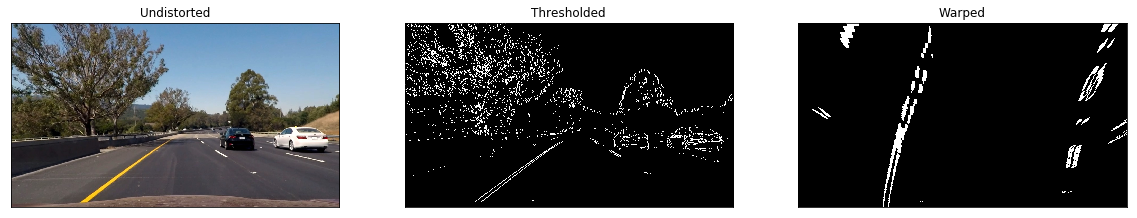

In [17]:
img = cv2.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)
result_stacked, result_combined = binary_threshold(img)
warped = cv2.warpPerspective(result_combined, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(20,14))
plt.subplot(1, 3, 1)
plt.title('Undistorted')
plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.title('Thresholded')
plt.xticks([])
plt.yticks([])
plt.imshow(result_combined, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Warped')
plt.xticks([])
plt.yticks([])
plt.imshow(warped, cmap='gray')

Next a histogram of the lower half of the warped image is taken. The histogram is shown in the image on the right below. By taking the histogram, the non-zero pixels can be counted vertically to identify where we are most likely to find lane lines (which will be non-zero). By measuring where the peak of the histogram is, the base position of the left and right lane lines can be identified. 

Left Lane Base Position: 309 pixels:
Right Lane Base Position: 1002 pixels


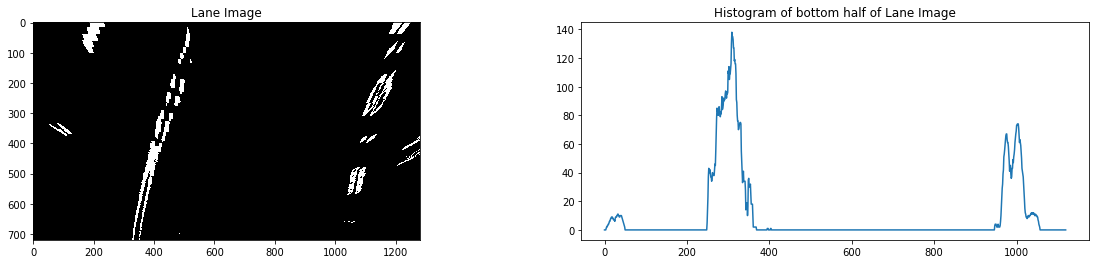

In [18]:
# Get lane base points and the histogram. 
leftx_base, rightx_base, histogram = find_base(warped)

# Plot lane image and histogram
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title('Lane Image')
plt.imshow(warped, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Histogram of bottom half of Lane Image')
plt.plot(histogram)

print("Left Lane Base Position: {} pixels:".format(leftx_base))
print("Right Lane Base Position: {} pixels".format(rightx_base))

## Finding Lane Lines and Plotting Fit
After the base points have been identified, the following shows the general approach to lane finding. The warped image, is split in to 9 sections. Starting from the bottom most section, we use the `leftx_base` and `rightx_base` previously identified to be the starting positions to execute the search for non-zero pixels. The search is carried out within a window around where the lane lines are believed to be. Each window has a width of 200 pixels centered around the starting position and a height of 1/9th the height of the image. All non-zero pixels in this window are identified and stored in `left_lane_inds` and `right_lane_inds`.  Depending on the number of non-zero pixels identified, the windows for the lane line scanning is adjusted for the next section of the image. The process repeats as we progress through the image. 

In the end, a polynomial fit is performed on all non-zero pixels found in the windows. The results are shown below, along with the windows used in the scanning. 

The radius of curvature and position of the car relative to the center of the road is identified using the method discussed in lesson 35. Aiding in the calculation are two values. `xm_per_meter` and `ym_per_meter`. These values tell us the conversion between the pixel world of the images to meters in the real world. The values used were those suggested by the lessons but confirmed by observing the bird's eye view image of the perspective transform on the straight line image. Assuming the lane lines are about 3.7 meters apart, this is represented by a space of roughly 700 pixels. Similarly, the dashed lane lines should be roughly 3 meters long and are roughly around 70-80 pixels in the image. By converting pixels to meters we can relate them to real world numbers. 

Radius Left: 2317.17549371 m
Radius Right: 1586.79506697 m
Position from Center: 0.205918651144 m


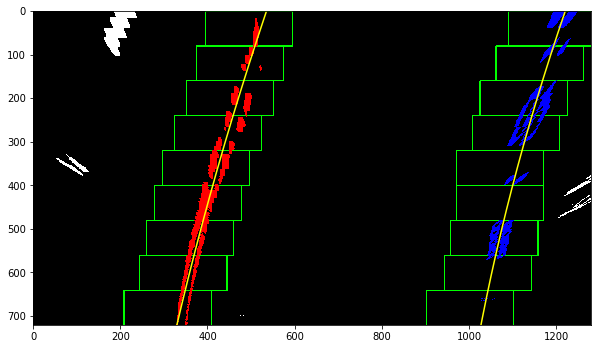

In [19]:
def mini_pipeline(img):
    out_img = np.dstack((warped, warped, warped))*255
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0]) # 0 to 719
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    plt.figure(figsize=(10,7))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Radius Left:', left_curverad, 'm')
    print('Radius Right:', right_curverad, 'm')
    
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    img_center = warped.shape[1]/2
    position = (lane_center - img_center) * xm_per_pix
    print('Position from Center:', position, 'm')

    
mini_pipeline(warped)

## Define Pipeline

Now that the general pipeline needed has been idenfitied, we develop a more robust pipeline for the video. The general steps of the pipeline are as follows.

Process Image
* Undistort
* Binary Threshold
* Transform

If Long Search
* Perform Sliding Window Search
* Get lane xy's
* Get new lane_fit_coeffs
* Average coeffs with historical coeff
* Get lane_fitx using Average Coeffs
* Get lane_curverad
* Get lane_pos_from_center
* Update Parameters

If Short Search
* Predict lane_fitx
* Search predicted_lane_fitx +/- margin
* Get lane xy's
* Get lane_fit_coeffs
* Average coeffs with historical coeff
* Get lane_fitx using Average Coeffs
* Get lane_curverad
* Get lane_pos_from_center
* Sanity Check
* If Sane: Update Parameters, reset counter
* If !Sane: Skip Frame, increment counter

Draw img

A major difference is the addition of a short search based on predictions of where the lane lines should be. The prediction is calculated using the polynomial fit coefficients of the previous frame. This is because we do not expect major changes between frames and makes finding the lane lines faster than doing the search from scratch again. 

Additionally, a few measures to increase robustness are included such as averaging of the lane polyfit coefficients. This ensures bad frames do not cause jumps in the lane finding. When bad frames are detected via sanity checks, the frame is skipped and calculations are not updated. For the lane prediction, historical values are used. 

In [20]:
def process_image(img):

    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    ym_per_pix = 3/72 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 10

    # Undistort Image and Perform Perspective Transform
    img = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)
    result_stacked, result_combined = binary_threshold(img)
    warped = cv2.warpPerspective(result_combined, M, img_size, flags=cv2.INTER_LINEAR)

    nwindows = 9
    window_height = np.int(warped.shape[0]/nwindows)

    img_center = warped.shape[1]/2
    nonzerox, nonzeroy = find_nonzeros(warped)

    #If did not detect lanes previously, do long search, else short search. 
    if ((left_lane.detected == False) or (right_lane.detected == False)):
        # Search from scratch
        new_detection = True
        # Use histogram detection to find base points. 
        leftx_base, rightx_base, histogram = find_base(warped)

        # Set current position equal to base points. These will be updated for each window.
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through each window
        for window in range(nwindows):
            # Identify the nonzero pixels in x and y within the window           
            good_left_inds, good_right_inds = find_lane_in_window(warped, window, window_height, leftx_current, rightx_current, 
                                                                  margin, nonzerox, nonzeroy)
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 


        # Fit a second order polynomial to each 1
        left_fit = get_poly_coeffs(lefty, leftx)
        right_fit = get_poly_coeffs(righty, rightx)


        # Average the new coeffs with historical
        if left_lane.best_fit is None:
            avg_left_fit = left_fit 
            avg_right_fit = right_fit

        else:
            avg_left_fit = [(left_lane.best_fit[0]*10+left_fit[0])/11,
                            (left_lane.best_fit[1]*10+left_fit[1])/11,
                            (left_lane.best_fit[2]*10+left_fit[2])/11]
            avg_right_fit = [(right_lane.best_fit[0]*10+right_fit[0])/11,
                             (right_lane.best_fit[1]*10+right_fit[1])/11,
                             (right_lane.best_fit[2]*10+right_fit[2])/11]
                                 
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0]) # 0 to 719
        #left_fitx = get_fittedx(ploty, left_fit)
        #right_fitx = get_fittedx(ploty, right_fit)
        left_fitx = get_fittedx(ploty, avg_left_fit)
        right_fitx = get_fittedx(ploty, avg_right_fit)
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = get_poly_coeffs(ploty*ym_per_pix, left_fitx*xm_per_pix)
        right_fit_cr = get_poly_coeffs(ploty*ym_per_pix, right_fitx*xm_per_pix)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
        left_lane.current_fit = left_fit
        right_lane.current_fit = right_fit
        left_lane.recent_xfitted.append(left_fitx)
        right_lane.recent_xfitted.append(right_fitx)
        left_lane.radius_of_curvature = left_curverad
        right_lane.radius_of_curvature = right_curverad
        left_lane.line_base_pos = left_fitx[-1] - img_center
        right_lane.line_base_pos = right_fitx[-1] - img_center
        
        left_lane.recent_fit.append(left_fit)
        right_lane.recent_fit.append(right_fit)

        if len(left_lane.recent_fit) > 0:
            left_lane.best_fit = np.mean(left_lane.recent_fit, axis=0)
            right_lane.best_fit = np.mean(right_lane.recent_fit, axis = 0)

        left_lane.detected = True
        right_lane.detected = True
        sanity = True

    else:
        new_detection = False
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
        
        # Predict non-zero x values based on past fit. 
        left_non_zerox = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
        right_non_zerox = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
        
        # Set search range based on margin setting. 
        left_lower_xlim = left_non_zerox - margin    # Left-side margin for left lane
        left_upper_xlim = left_non_zerox + margin    # Right-side margin for left lane
        right_lower_xlim = right_non_zerox - margin
        right_upper_xlim = right_non_zerox + margin

        # Obtain corresponding indices
        left_lane_inds = ((nonzerox > left_lower_xlim) & (nonzerox < left_upper_xlim))
        right_lane_inds = ((nonzerox > right_lower_xlim) & (nonzerox < right_upper_xlim))
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Skip frame if no points were found. 
        if len(leftx)==0 or len(lefty)==0 or len(righty)==0 or len(rightx)==0:
            left_fit = left_lane.best_fit
            right_fit = right_lane.best_fit
        else:
            # Fit a second order polynomial to each 2
            left_fit = get_poly_coeffs(lefty, leftx)
            right_fit = get_poly_coeffs(righty, rightx)

        # Average the new coeffs with historical
        if left_lane.best_fit is None:
            avg_left_fit = left_fit 
            avg_right_fit = right_fit

        else:
            avg_left_fit = [(left_lane.best_fit[0]*10+left_fit[0])/11,
                            (left_lane.best_fit[1]*10+left_fit[1])/11,
                            (left_lane.best_fit[2]*10+left_fit[2])/11]
            avg_right_fit = [(right_lane.best_fit[0]*10+right_fit[0])/11,
                             (right_lane.best_fit[1]*10+right_fit[1])/11,
                             (right_lane.best_fit[2]*10+right_fit[2])/11]
            
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0]) # 0 to 719

        #left_fitx = get_fittedx(ploty, left_fit)
        #right_fitx = get_fittedx(ploty, right_fit)
        left_fitx = get_fittedx(ploty, avg_left_fit)
        right_fitx = get_fittedx(ploty, avg_right_fit)

        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = get_poly_coeffs(ploty*ym_per_pix, left_fitx*xm_per_pix)
        right_fit_cr = get_poly_coeffs(ploty*ym_per_pix, right_fitx*xm_per_pix)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
#        if sanity_check_curve(left_lane, left_curverad) and sanity_check_curve(right_lane, right_curverad) and sanity_check_width(left_fitx, right_fitx):
        if sanity_check_curve(left_lane, left_curverad) and sanity_check_curve(right_lane, right_curverad) and sanity_check_width(left_fitx, right_fitx):
            left_lane.current_fit = left_fit
            right_lane.current_fit = right_fit
            left_lane.recent_xfitted.append(left_fitx)
            right_lane.recent_xfitted.append(right_fitx)
            left_lane.radius_of_curvature = left_curverad
            right_lane.radius_of_curvature = right_curverad
            left_lane.line_base_pos = left_fitx[-1] - img_center
            right_lane.line_base_pos = right_fitx[-1] - img_center
            left_lane.recent_fit.append(left_fit)
            right_lane.recent_fit.append(right_fit)
            
            if len(left_lane.recent_fit) > 0:
                left_lane.best_fit = np.mean(left_lane.recent_fit, axis=0)
                right_lane.best_fit = np.mean(right_lane.recent_fit, axis=0)            
        
            
            left_lane.num_skipped = 0
            right_lane.num_skipped = 0
            
            left_lane.detected = True
            right_lane.detected = True
            sanity = True

        else:
            if left_lane.num_skipped >= 10:
                left_lane.detected = False
                right_lane.detected = False

            else:
                left_lane.num_skipped +=1
                right_lane.num_skipped +=1

            sanity = False
    
    result = draw_lane_lines(img, warped, left_lane.recent_xfitted[-1], right_lane.recent_xfitted[-1], ploty)
    result = annotate_frame(result, left_lane, right_lane, sanity, xm_per_pix)

    return result

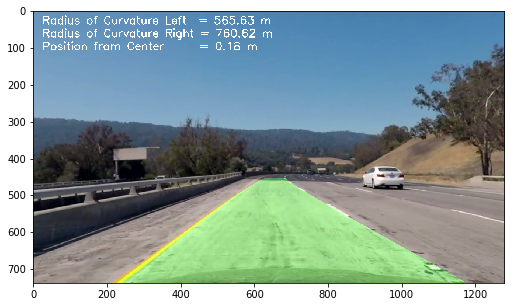

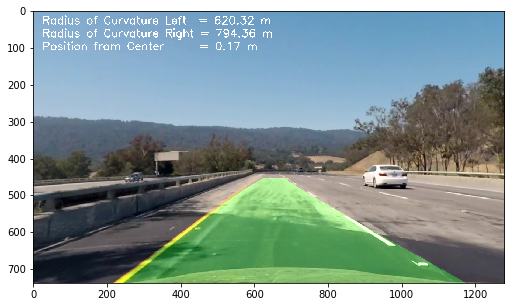

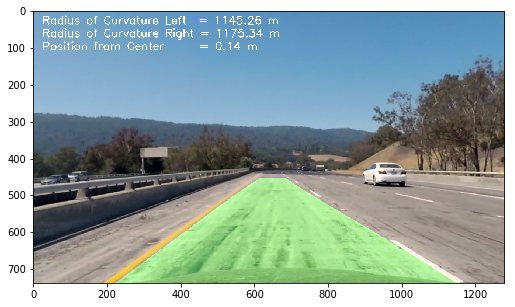

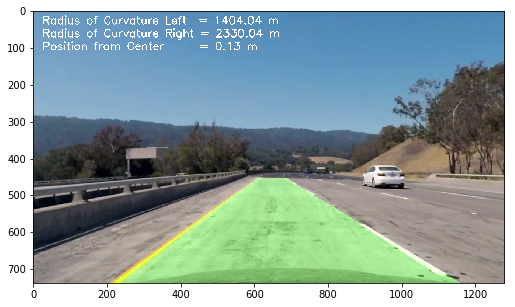

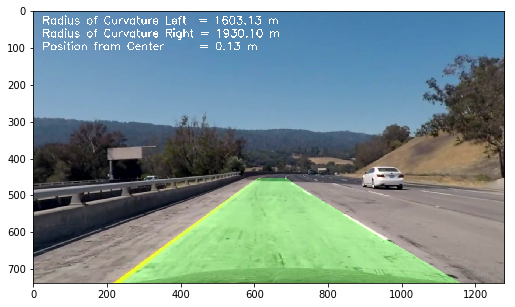

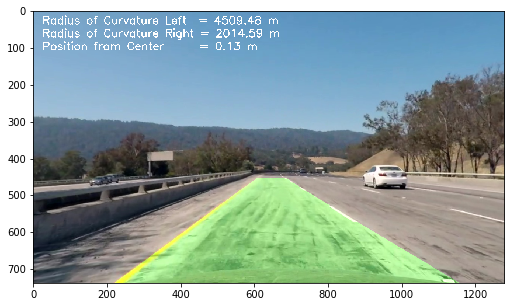

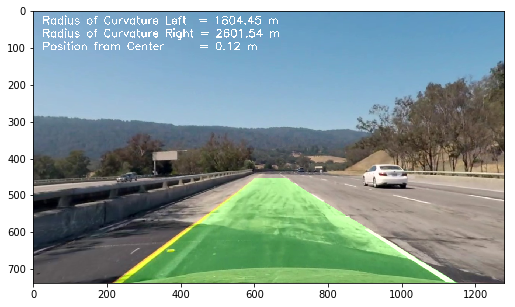

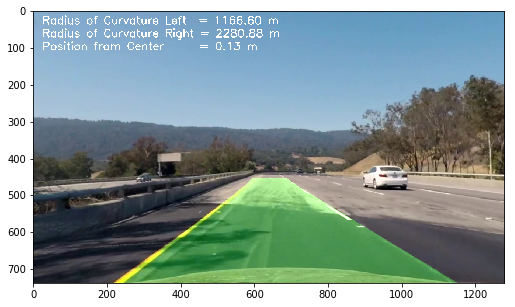

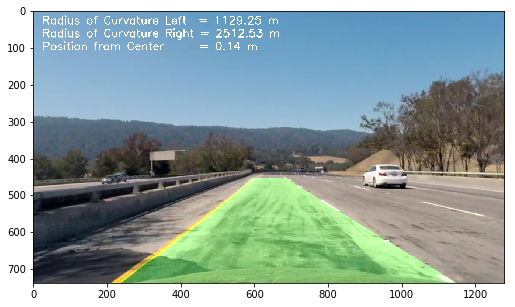

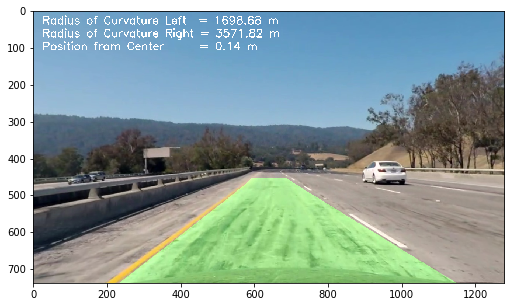

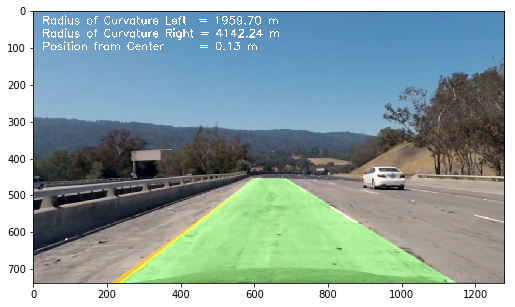

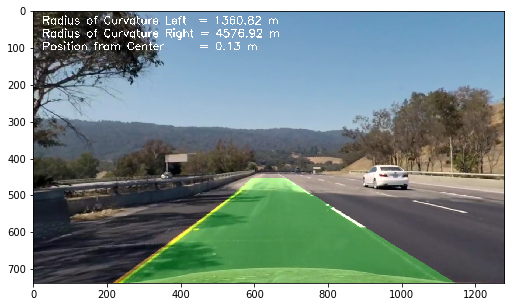

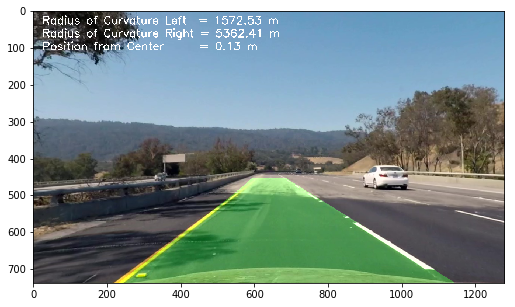

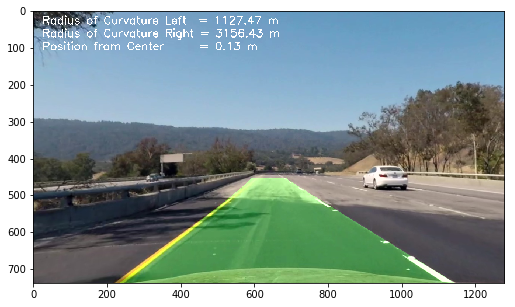

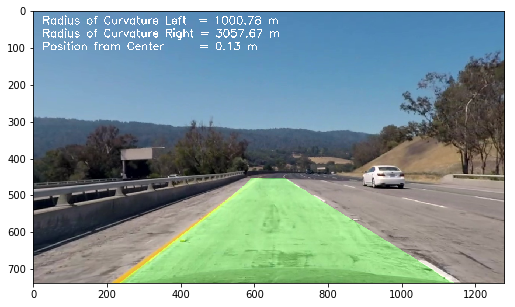

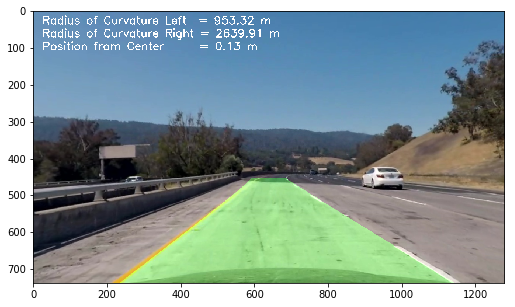

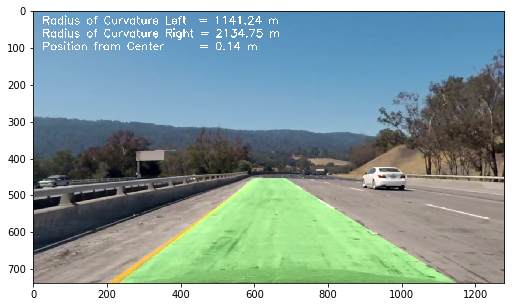

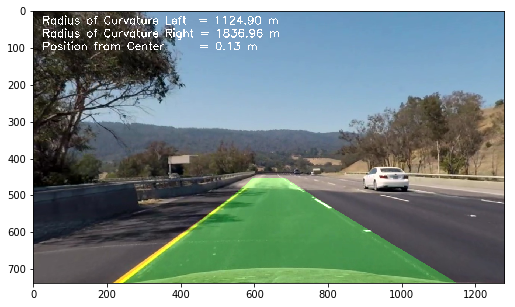

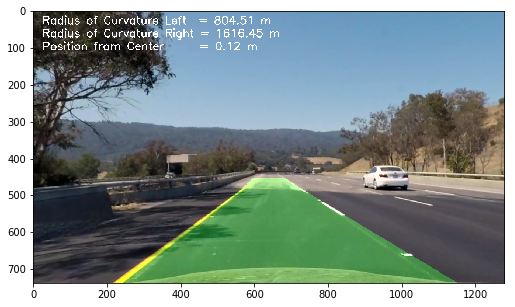

In [21]:
# Test Multi Image Pipeline
test_files = glob.glob('test_images_seq/*.jpg')

left_lane = Line()
right_lane = Line()

for i in range(len(test_files)):
    img = cv2.imread(test_files[i])
    img_size = (img.shape[1], img.shape[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)

    test_result = process_image(img)
    plt.figure(figsize=(10,5))
    plt.imshow(test_result)


## Testing with video

In [22]:
video_savefile = 'output_files/project_output.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")

In [23]:
left_lane = Line()
right_lane = Line()

video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_savefile, audio=False)

[MoviePy] >>>> Building video output_files/project_output.mp4
[MoviePy] Writing video output_files/project_output.mp4


100%|█████████▉| 1260/1261 [02:06<00:00, 10.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_files/project_output.mp4 

CPU times: user 2min 42s, sys: 16.9 s, total: 2min 59s
Wall time: 2min 6s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_savefile))

## Testing with Challenge Video (Optional)

In [25]:
video_savefile = 'output_files/challenge_output.mp4'
clip1 = VideoFileClip("test_videos/challenge_video.mp4")

left_lane = Line()
right_lane = Line()

video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_savefile, audio=False)

[MoviePy] >>>> Building video output_files/challenge_output.mp4
[MoviePy] Writing video output_files/challenge_output.mp4


100%|██████████| 485/485 [00:47<00:00, 10.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_files/challenge_output.mp4 

CPU times: user 1min 1s, sys: 6.62 s, total: 1min 7s
Wall time: 48.3 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_savefile))

## Discussion

The code works well during open stretches where there are minimal shadows and the contrast between the road and the lanes are optimal. A lot of trial and error went into combating difficulties handling shadows and changes in road texture. As a result, code could use refactoring. Some of the techniques used to make the program robust are discussed below. 

The polyfit coefficients are tracked and averaged to deal with sudden bad frames. To detect bad frames, a sanity check is performed on the detected lanes curvature. If we get a sudden really sharp radius of curvature, I ignore the frame because it's highly likely that the program didn't track the lanes. Also, a sanity check is performed on the distance between the lanes. If the distance between the lane pixels are much greater than or much smaller than 3.7 m, I ignore the frame because it's highly possible that the lane detection didn't track well. In the event we detect such bad frames, the historical averaged coefficients are used to generate the lane lines. Once we see 10 consecutive bad frames, the program executes the long search for new lane lines. 

Improvements could be made in the preprocessingt / thresholding to eliminate more 'noise'. Despite the gaussian blur and thresholding, edges are still detected for reflectors in the road, streaks in the road, the side walls, etc. These false edges skew the calculation of the lane line position. This is particularly evident when the road switches from black asphalt to the lighter colored road with lots of shadows. 

Additionally, when the sanity check fails, both left and right lane calculations are discarded, even if calculations for one lane may be ok. An improvement could be decoupling this relationship which would allow us to update lane calculations more frequently and thus keep it more robust. 

Hypothetical cases that would cause the pipeline to fail. 
1. Prolonged variation in road texture either by shadows, road characteristics / color / material. This would cause the pipeline to continuously reject frames while performing a long search every 10 frames or so. 

2. Low light conditions such as night time or prolonged shadows. The pipeline has only been tested on relatively bright conditions as shown in the video. 

3. Sharp curve radius could throw off the algorithm due to limits we set through the perspective transform or the sanity check during lane detection. We may not capture or may end up rejecting sharp turns that may not exist on highways but could exist on local roads. 

4. Roads with faded lane markings, lots of dirt / sand / snow. The roads tested were relatively high contrast. Better algorithm for edge detection or other methods to position the car may be required. 

### Thoughts on the Challenge Video
The challenge video introduced new elements that were difficult for the algorithm to handle. The algorithm mistook other contrasting surfaces such as the highway divider, shadows, road signs, or road repair marks to be lane lines. One way to tackle this issue could be to restrict the lane line start points to a narrow range. This way, it would be less likely to be influenced by the divider or road repair marks which appear towards the far left and center of view, respectively. Better edge detection algorithm should be investigated to see if we can reduce detection of non-white or non-yellow edge lines. 